In [2]:
import json
from pathlib import Path
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

### Read data

In [3]:
data_path = Path('data/hse')

ratings = pd.read_csv(data_path / 'train_ratings.csv')
trainsactions = pd.read_csv(data_path / 'train_transactions.csv')

with open(data_path / 'catalogue.json', 'r') as f:
    meta_raw = json.load(f)

In [4]:
trainsactions

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,2570,408484,S,4.430483e+07,0,5,90
1,8522,408484,S,4.430481e+07,0,5,90
2,7642,428798,S,4.430480e+07,35,5,90
3,8330,428798,S,4.430480e+07,6350,5,90
4,8546,408484,S,4.430477e+07,0,5,90
...,...,...,...,...,...,...,...
7075303,2252,180823,S,4.173063e+07,2503,0,11
7075304,8436,458827,S,4.173063e+07,8360,0,50
7075305,8888,50431,S,4.173063e+07,5763,0,11
7075306,6099,59148,S,4.173063e+07,6831,0,50


In [5]:
ratings

,user_uid,element_uid,rating,ts
0,571252,3783,10,4.408089e+07
1,571252,5616,10,4.401264e+07
2,571252,2639,10,4.401099e+07
3,63140,2693,10,4.421830e+07
4,63140,9999,10,4.406648e+07
...,...,...,...,...
319240,264455,7513,10,4.173274e+07
319241,459192,1942,9,4.173266e+07
319242,359611,8895,10,4.173203e+07
319243,349307,3336,10,4.173197e+07


### Train/test split

In [7]:
trainsactions['split_rank_per_user'] = (
    trainsactions
    .groupby('user_uid')['ts']
    .rank('first', ascending=False)
    .astype('int32')
)

In [8]:
trainsactions

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,split_rank_per_user
0,2570,408484,S,4.430483e+07,0,5,90,1
1,8522,408484,S,4.430481e+07,0,5,90,2
2,7642,428798,S,4.430480e+07,35,5,90,1
3,8330,428798,S,4.430480e+07,6350,5,90,2
4,8546,408484,S,4.430477e+07,0,5,90,3
...,...,...,...,...,...,...,...,...
7075303,2252,180823,S,4.173063e+07,2503,0,11,18
7075304,8436,458827,S,4.173063e+07,8360,0,50,17
7075305,8888,50431,S,4.173063e+07,5763,0,11,28
7075306,6099,59148,S,4.173063e+07,6831,0,50,85


In [9]:
trainsactions_train = (
    trainsactions
    .query('split_rank_per_user > 2')
    .drop(columns=['split_rank_per_user'])
)

trainsactions_test = (
    trainsactions
    .query('split_rank_per_user <= 2')
    .drop(columns=['split_rank_per_user'])
)

In [10]:
trainsactions_train.to_parquet('data/als_transactions_train.parquet', index=False)
trainsactions_test.to_parquet('data/als_transactions_test.parquet', index=False)

In [11]:
trainsactions_train

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
4,8546,408484,S,4.430477e+07,0,5,90
5,9817,428798,S,4.430474e+07,4302,5,90
6,627,408484,S,4.430472e+07,0,5,90
7,3017,408484,S,4.430453e+07,777,0,90
12,6272,193139,S,4.430448e+07,7,0,50
...,...,...,...,...,...,...,...
7075303,2252,180823,S,4.173063e+07,2503,0,11
7075304,8436,458827,S,4.173063e+07,8360,0,50
7075305,8888,50431,S,4.173063e+07,5763,0,11
7075306,6099,59148,S,4.173063e+07,6831,0,50


### Preprocess metainformation

In [12]:
def meta_to_df(meta_raw):
    element_uid = []
    duration = []
    type_ = []
    for k, v in meta_raw.items():
        element_uid.append(int(k))
        duration.append(float(v['duration']) * 60)
        type_.append(v['type'])
    meta = pd.DataFrame({
        'element_uid': element_uid,
        'duration': duration,
        'type': type_,
    })
    return meta

meta = meta_to_df(meta_raw)

In [13]:
meta

,element_uid,duration,type
0,1983,8400.0,movie
1,3783,6600.0,movie
2,5208,5400.0,movie
3,9744,7200.0,movie
4,1912,6600.0,movie
...,...,...,...
10195,6643,3000.0,series
10196,166,1800.0,series
10197,9242,2400.0,series
10198,6427,1800.0,series


### Compute score for each transaction

In [14]:
trainsactions_with_meta = (
    trainsactions_train
    .merge(meta[[
        'element_uid', 
        'duration',
        'type',
    ]], on='element_uid', how='left')
)

trainsactions_with_meta['watched_ratio'] = (
    trainsactions_with_meta['watched_time'] / 
    trainsactions_with_meta['duration']
)

def score_transaction(t):
    score = 1
    if t['duration'] > 0:
        if t['type'] == 'movie':
            if t['watched_ratio'] > 0.3:
                score = int(t['watched_ratio'] * 9) + 1
        else:
            if t['watched_ratio'] > 1:
                score = int(t['watched_ratio'] / 2) + 1
    return min(score, 10)

trainsactions_with_meta['score'] = trainsactions_with_meta.apply(score_transaction, axis=1)

In [15]:
trainsactions_with_meta

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,duration,type,watched_ratio,score
0,8546,408484,S,4.430477e+07,0,5,90,4800.0,movie,0.000000,1
1,9817,428798,S,4.430474e+07,4302,5,90,7200.0,movie,0.597500,6
2,627,408484,S,4.430472e+07,0,5,90,5400.0,movie,0.000000,1
3,3017,408484,S,4.430453e+07,777,0,90,5400.0,movie,0.143889,1
4,6272,193139,S,4.430448e+07,7,0,50,6000.0,movie,0.001167,1
...,...,...,...,...,...,...,...,...,...,...,...
6565605,2252,180823,S,4.173063e+07,2503,0,11,6000.0,movie,0.417167,4
6565606,8436,458827,S,4.173063e+07,8360,0,50,5400.0,movie,1.548148,10
6565607,8888,50431,S,4.173063e+07,5763,0,11,6600.0,movie,0.873182,8
6565608,6099,59148,S,4.173063e+07,6831,0,50,7200.0,movie,0.948750,9


In [16]:
trainsactions_with_meta_and_ratings = (
    trainsactions_with_meta
    .merge(
        ratings[['user_uid', 'element_uid', 'rating']],
        on=['user_uid', 'element_uid'],
        how='outer'
    )
)

trainsactions_with_meta_and_ratings['score'].fillna(
    trainsactions_with_meta_and_ratings['rating'], inplace=True)

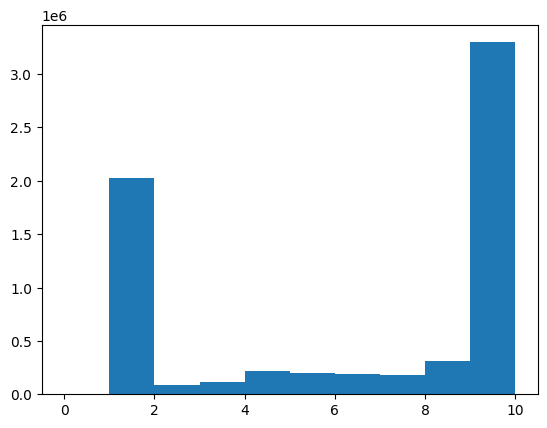

In [17]:
plt.hist(trainsactions_with_meta_and_ratings['score'].values, range=[0, 10])
plt.show()

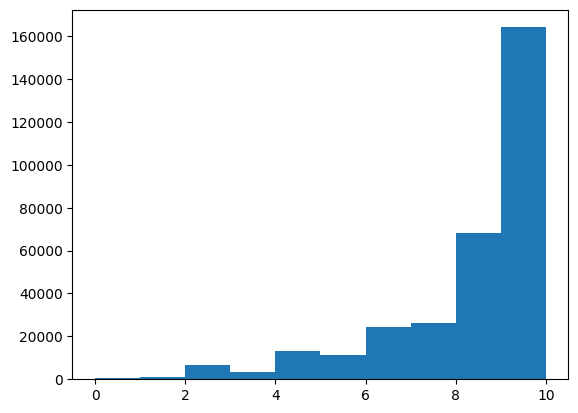

In [18]:
plt.hist(ratings['rating'].values)
plt.show()

### Apply TF-IDF encoding for transactions

In [19]:
from sklearn.preprocessing import LabelEncoder

def encode_tfidf_coo(transactions: pd.DataFrame) -> pd.DataFrame:
    score_sum_per_user = (
        transactions
        .groupby('user_uid')['score']
        .transform('sum')
    )
    user_count_per_element = (
        transactions
        .groupby('element_uid')['user_uid']
        .transform('size')
    )
    tf = transactions['score'].values / score_sum_per_user.values
    idf = np.log(len(score_sum_per_user) / user_count_per_element.values)
    
    tfidf = transactions[['user_uid', 'element_uid']].copy()
    tfidf['value'] = tf * idf

    return tfidf


def encode_tfidf(transactions: pd.DataFrame) -> Tuple[LabelEncoder, LabelEncoder, csr_matrix]:
    tfidf = encode_tfidf_coo(transactions)
    
    n_users = tfidf['user_uid'].nunique()
    n_elements = tfidf['element_uid'].nunique()

    user_encoder = LabelEncoder()
    element_encoder = LabelEncoder()
    user_index = user_encoder.fit_transform(transactions['user_uid'].values)
    element_index = element_encoder.fit_transform(transactions['element_uid'].values)

    tfidf_csr = csr_matrix(
        (
            tfidf['value'].astype('float32').values,
            (user_index, element_index)
        ),
        shape=(n_users, n_elements)
    )

    return user_encoder, element_encoder, tfidf_csr


user_encoder, element_encoder, transactions_csr = \
    encode_tfidf(trainsactions_with_meta_and_ratings)

In [20]:
transactions_csr

<254849x8545 sparse matrix of type '<class 'numpy.float32'>'
	with 6636716 stored elements in Compressed Sparse Row format>

In [21]:
print(f'sparsity = {(1 - transactions_csr.nnz / np.prod(transactions_csr.shape)) * 100:.4f}%') 

sparsity = 99.6952%


### Train ALS

In [22]:
from implicit.als import AlternatingLeastSquares

transactions_csr.data = 1 + 40.0 * transactions_csr.data

als = AlternatingLeastSquares(factors=128, iterations=30, calculate_training_loss=True)
als.fit(transactions_csr)

  0%|          | 0/30 [00:00<?, ?it/s]

### Infer ALS recommendations 

In [23]:
recommendations_matrix, recommendations_scores = als.recommend(
    np.arange(0, transactions_csr.shape[0]), 
    transactions_csr, 
    N=200, 
    filter_already_liked_items=True
)

In [24]:
recommendations_matrix

array([[6250, 6971, 8374, ..., 1224,  233, 4618],
       [ 690, 2129,  847, ...,  317, 1020, 1213],
       [2879, 2919, 3050, ..., 7575, 4688, 4677],
       ...,
       [8239, 6678, 1305, ..., 1066,  504, 4437],
       [1140,   55, 2707, ..., 5771, 4505, 7036],
       [2042, 3265, 2622, ..., 8253, 4954,  793]], dtype=int32)

In [25]:
recommendations_scores

array([[0.85130495, 0.7552573 , 0.7503804 , ..., 0.28609535, 0.28609064,
        0.2856443 ],
       [0.92868954, 0.6993675 , 0.66901016, ..., 0.16964893, 0.16945201,
        0.16942549],
       [1.0205833 , 0.77786326, 0.7564025 , ..., 0.25371364, 0.25287837,
        0.25053474],
       ...,
       [0.7751763 , 0.7624321 , 0.6970429 , ..., 0.31756467, 0.31474093,
        0.31358165],
       [0.82928896, 0.8167012 , 0.78149325, ..., 0.1917175 , 0.19151393,
        0.19149628],
       [0.8458739 , 0.650429  , 0.62853783, ..., 0.16636641, 0.1662345 ,
        0.16579302]], dtype=float32)

In [26]:
def als_recommendations_to_df(
    recommendations_matrix: np.ndarray, 
    recommendations_scores: np.ndarray,
    user_encoder: LabelEncoder, 
    item_encoder: LabelEncoder,
    user_key = 'user_id',
    item_key = 'item_id'
) -> pd.DataFrame:
    recommendations_indices = pd.DataFrame({
        'user_index': np.arange(0, len(recommendations_matrix)),
        'item_index': list(recommendations_matrix),
        'score': list(recommendations_scores),
    })

    user_mapping = pd.DataFrame({
        'user_index': np.arange(0, len(user_encoder.classes_)),
        user_key: user_encoder.classes_,
    })

    item_mapping = pd.DataFrame({
        'item_index': np.arange(0, len(item_encoder.classes_)),
        item_key: item_encoder.classes_,
    })

    recommendations = (
        recommendations_indices
        .merge(
            user_mapping,
            on='user_index',
            how='left',
        )
        .drop(columns=['user_index'])
        .explode(['item_index', 'score'], ignore_index=True)
        .merge(
            item_mapping,
            on='item_index',
            how='left',
        )
        .drop(columns=['item_index'])
    )

    return recommendations


recommendations = als_recommendations_to_df(
    recommendations_matrix,
    recommendations_scores,
    user_encoder,
    element_encoder,
    user_key='user_uid',
    item_key='element_uid',
)

In [27]:
recommendations

,score,user_uid,element_uid
0,0.851305,0,7449
1,0.755257,0,8330
2,0.75038,0,9992
3,0.676227,0,7239
4,0.657848,0,51
...,...,...,...
50969795,0.167205,593489,9836
50969796,0.166887,593489,9693
50969797,0.166366,593489,9851
50969798,0.166234,593489,5927


In [28]:
recommendations.to_parquet('data/als_recommendations.parquet', index=False)